In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import tan, sin, cos, sqrt, atan2
from numpy.random import randn

from filterpy.stats import plot_covariance_ellipse
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints

In [2]:
def move(x, dt, u, wheelbase):
    hdg = x[2]
    vel = u[0]
    steering_angle = u[1]
    dist = vel * dt

    if abs(steering_angle) > 0.001: # is robot turning?
        beta = (dist / wheelbase) * tan(steering_angle)
        r = wheelbase / tan(steering_angle) # radius

        sinh, sinhb = sin(hdg), sin(hdg + beta)
        cosh, coshb = cos(hdg), cos(hdg + beta)
        return x + np.array([-r*sinh + r*sinhb, 
                              r*cosh - r*coshb, beta])
    else: # moving in straight line
        return x + np.array([dist*cos(hdg), dist*sin(hdg), 0])

In [3]:
def normalize_angle(x):
    x = x % (2 * np.pi)    # force in range [0, 2 pi)
    if x > np.pi:          # move to [-pi, pi)
        x -= 2 * np.pi
    return x

In [4]:
def residual_h(a, b):
    y = a - b
    # data in format [dist_1, bearing_1, dist_2, bearing_2,...]
    for i in range(0, len(y), 2):
        y[i + 1] = normalize_angle(y[i + 1])
    return y

def residual_x(a, b):
    y = a - b
    y[2] = normalize_angle(y[2])
    return y

In [5]:
def Hx(x, landmarks):
    """ takes a state variable and returns the measurement
    that would correspond to that state. """
    hx = []
    for lmark in landmarks:
        px, py = lmark
        dist = sqrt((px - x[0])**2 + (py - x[1])**2)
        angle = atan2(py - x[1], px - x[0])
        hx.extend([dist, normalize_angle(angle - x[2])])
    return np.array(hx)

In [6]:
def state_mean(sigmas, Wm):
    x = np.zeros(3)

    sum_sin = np.sum(np.dot(np.sin(sigmas[:, 2]), Wm))
    sum_cos = np.sum(np.dot(np.cos(sigmas[:, 2]), Wm))
    x[0] = np.sum(np.dot(sigmas[:, 0], Wm))
    x[1] = np.sum(np.dot(sigmas[:, 1], Wm))
    x[2] = atan2(sum_sin, sum_cos)
    return x

def z_mean(sigmas, Wm):
    z_count = sigmas.shape[1]
    x = np.zeros(z_count)

    for z in range(0, z_count, 2):
        sum_sin = np.sum(np.dot(np.sin(sigmas[:, z+1]), Wm))
        sum_cos = np.sum(np.dot(np.cos(sigmas[:, z+1]), Wm))

        x[z] = np.sum(np.dot(sigmas[:,z], Wm))
        x[z+1] = atan2(sum_sin, sum_cos)
    return x

In [7]:
dt = 1.0
wheelbase = 0.5

In [8]:
def run_localization(
    cmds, landmarks, sigma_vel, sigma_steer, sigma_range, 
    sigma_bearing, ellipse_step=1, step=10):

    plt.figure(figsize=(12,12))
    points = MerweScaledSigmaPoints(n=3, alpha=.00001, beta=2, kappa=0, 
                                    subtract=residual_x)
    ukf = UKF(dim_x=3, dim_z=2*len(landmarks), fx=move, hx=Hx,
              dt=dt, points=points, x_mean_fn=state_mean, 
              z_mean_fn=z_mean, residual_x=residual_x, 
              residual_z=residual_h)

    ukf.x = np.array([2, 6, .3])
    ukf.P = np.diag([.1, .1, .05])
    ukf.R = np.diag([sigma_range**2, 
                     sigma_bearing**2]*len(landmarks))
    ukf.Q = np.eye(3)*0.0001
    
    sim_pos = ukf.x.copy()
    
    # plot landmarks
    if len(landmarks) > 0:
        plt.scatter(landmarks[:, 0], landmarks[:, 1], 
                    marker='s', s=60)
    
    track = []
    for i, u in enumerate(cmds):     
        sim_pos = move(sim_pos, dt/step, u, wheelbase)
        track.append(sim_pos)

        if i % step == 0:
            ukf.predict(u=u, wheelbase=wheelbase)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ukf.x[0], ukf.x[1]), ukf.P[0:2, 0:2], std=6,
                     facecolor='k', alpha=0.3)

            x, y = sim_pos[0], sim_pos[1]
            z = []
            for lmark in landmarks:
                dx, dy = lmark[0] - x, lmark[1] - y
                d = sqrt(dx**2 + dy**2) + randn()*sigma_range
                bearing = atan2(lmark[1] - y, lmark[0] - x)
                a = (normalize_angle(bearing - sim_pos[2] + 
                     randn()*sigma_bearing))
                z.extend([d, a])            
            ukf.update(z, landmarks=landmarks)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ukf.x[0], ukf.x[1]), ukf.P[0:2, 0:2], std=6,
                     facecolor='g', alpha=0.8)
    track = np.array(track)
    plt.plot(track[:, 0], track[:,1], color='k', lw=2)
    plt.axis('equal')
    plt.grid(True)
    plt.title("UKF Robot localization")
    plt.show()
    return ukf

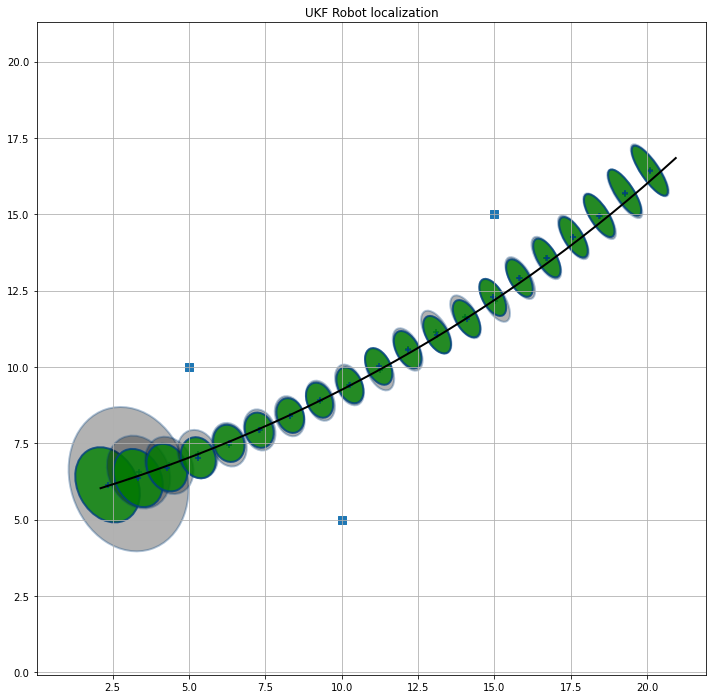

Final P: [0.00975853 0.01860768 0.00070812]


In [9]:
landmarks = np.array([[5, 10], [10, 5], [15, 15]])
cmds = [np.array([1.1, .01])] * 200
ukf = run_localization(
    cmds, landmarks, sigma_vel=0.1, sigma_steer=np.radians(1),
    sigma_range=0.3, sigma_bearing=0.1)
print('Final P:', ukf.P.diagonal())

In [10]:
landmarks = np.array([[5, 10], [10, 5], [15, 15], [20, 5],
                      [0, 30], [50, 30], [40, 10]])
dt = 0.1
wheelbase = 0.5
sigma_range=0.3
sigma_bearing=0.1

def turn(v, t0, t1, steps):
    return [[v, a] for a in np.linspace(
                 np.radians(t0), np.radians(t1), steps)]  
    
# accelerate from a stop
cmds = [[v, .0] for v in np.linspace(0.001, 1.1, 30)]
cmds.extend([cmds[-1]]*50)

# turn left
v = cmds[-1][0]
cmds.extend(turn(v, 0, 2, 15))
cmds.extend([cmds[-1]]*100)

#turn right
cmds.extend(turn(v, 2, -2, 15))
cmds.extend([cmds[-1]]*200)

cmds.extend(turn(v, -2, 0, 15))
cmds.extend([cmds[-1]]*150)

cmds.extend(turn(v, 0, 1, 25))
cmds.extend([cmds[-1]]*100)

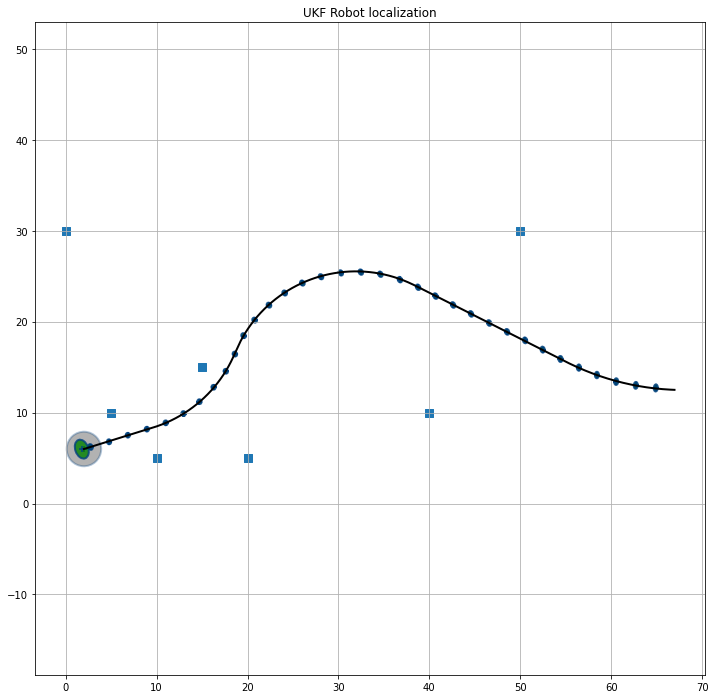

final covariance [0.00125206 0.004305   0.00043589]


In [11]:
ukf = run_localization(
    cmds, landmarks, sigma_vel=0.1, sigma_steer=np.radians(1),
    sigma_range=0.3, sigma_bearing=0.1, step=1,
    ellipse_step=20)
print('final covariance', ukf.P.diagonal())

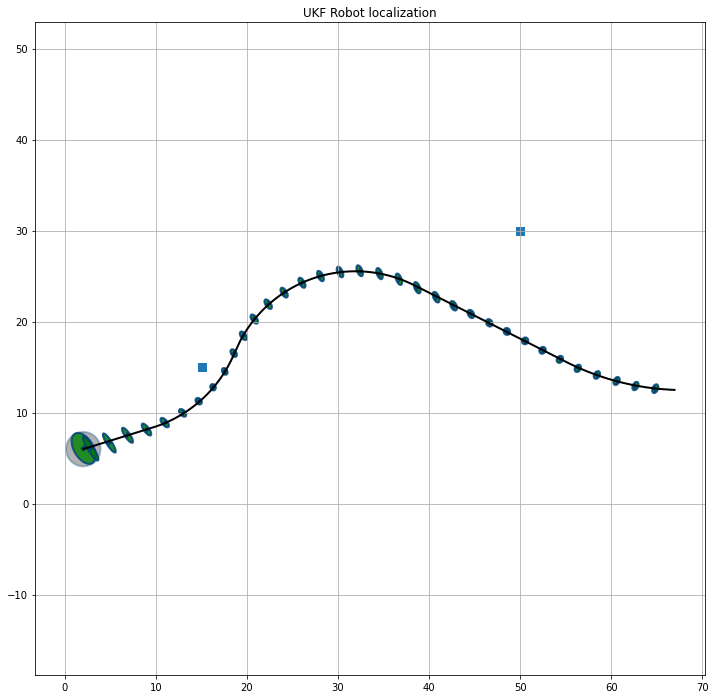

final covariance [0.00305502 0.00676776 0.00077025]


In [12]:
ukf = run_localization(
    cmds, landmarks[[2,5]], sigma_vel=0.1, sigma_steer=np.radians(1),
    sigma_range=0.3, sigma_bearing=0.1, step=1,
    ellipse_step=20)
print('final covariance', ukf.P.diagonal())